# Visualisasi

In [1]:
from os import path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text

%matplotlib inline
plt.style.use('bmh')

In [2]:
DATA_DIR = path.join(path.pardir, 'data')
PAN_DIR = path.join(DATA_DIR, 'pangenomes')
FIG_DIR = path.join(path.pardir, 'figs')

## 1. k-mers Manhattan Plot

In [3]:
antibiotic = 'ethambutol'

In [4]:
def get_pyseer(antibiotic):
    PYSEER_PATH = path.join(PAN_DIR, antibiotic, 'pyseer', 'pyseer.tsv')
    pyseer = pd.read_csv(PYSEER_PATH, sep='\t')
    return pyseer


def get_cluster2hash(antibiotic):
    KMERS_HASHES_PATH = path.join(PAN_DIR, antibiotic, 'panfeed1', 'kmers_to_hashes.tsv')
    hashes = pd.read_csv(KMERS_HASHES_PATH, sep='\t')
    return hashes


def extract_data(pyseer, cluster2hash):
    variants = pyseer['variant']

    neg_logp = -np.log10(pyseer['filter-pvalue'])
    neg_logp.name = 'neg_logp'

    cluster = cluster2hash[['cluster', 'hashed_pattern']].drop_duplicates()
    cluster.columns = ['cluster', 'variant']

    data = pd.concat([variants, neg_logp], axis=1)
    data = pd.merge(data, cluster, how='left', on='variant')
    data['position'] = data.index
    return data


def create_manhattan_plot(data, antibiotic, threshold):
    threshold = -np.log10(threshold)
    
    running_pos = 0
    cumulative_pos = []
    for cluster, group in data.groupby('cluster'):  
        cumulative_pos.append(group['position'] + running_pos)
        running_pos += group['position'].max()
    
    data['cumulative_pos'] = pd.concat(cumulative_pos)
    data['is_selected'] = data['neg_logp'] > threshold 

    g = sns.relplot(
        data=data,
        x='cumulative_pos',
        y='neg_logp',
        alpha=0.9,
        aspect=1.5,
        hue='is_selected',
        palette='colorblind',
        linewidth=0.3,
        s=25,
        legend=None
    )
    
    g.ax.axhline(threshold, linestyle='--', linewidth=1, color='black', alpha=0.6)
    g.ax.set_xlabel('COGs')
    g.ax.set_ylabel(r'$-\log_{10}$$(p$-$value)$')
    g.ax.set_xticks([], [])
    g.fig.suptitle(f'Assosiasi Kluster $k$-$mers$ terhadap Resistensi {antibiotic.title()}', y=1.01, size='large')

    data_adjust = data[data['neg_logp'] > threshold].sort_values('neg_logp', ascending=False).drop_duplicates(['cluster'])
    cluster_annotation = data_adjust.apply(lambda p : g.ax.annotate(p['cluster'], (p['cumulative_pos'], p['neg_logp'])), axis=1).to_list()
    adjust_text(
        cluster_annotation, 
        arrowprops = {'arrowstyle': '-|>', 'color': 'black', 'lw': 0.02}
    )
    
    return g


def run_manhattan_pipeline(antibiotic, threshold):
    pyseer = get_pyseer(antibiotic)
    cluster2hash = get_cluster2hash(antibiotic)
    data = extract_data(pyseer, cluster2hash)
    
    g = create_manhattan_plot(data, antibiotic, threshold)  
    g.fig.savefig(path.join(FIG_DIR, f'manhattan_{antibiotic}.png'), format='png', dpi=600, bbox_inches='tight')

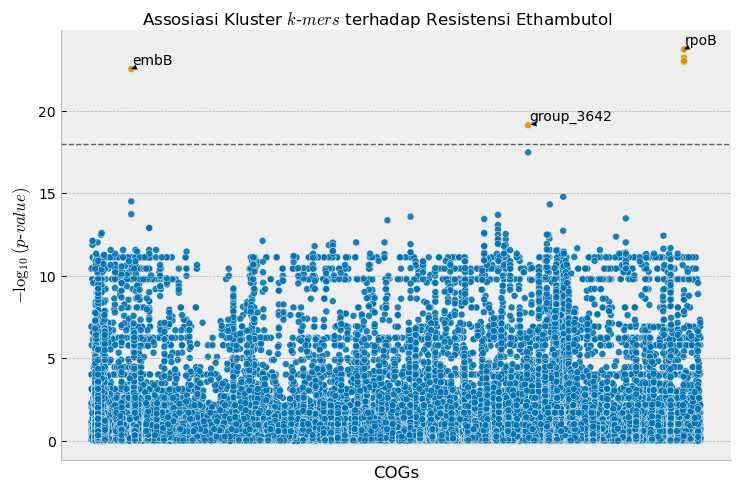

In [5]:
run_manhattan_pipeline('ethambutol', 1e-18)

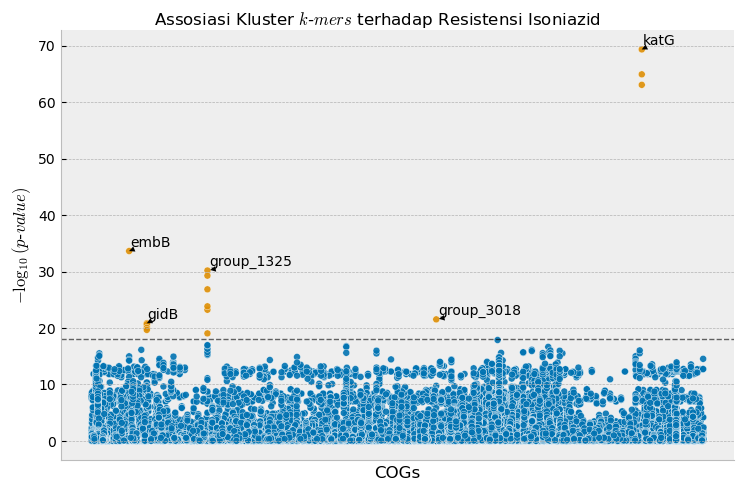

In [6]:
run_manhattan_pipeline('isoniazid', 1e-18)

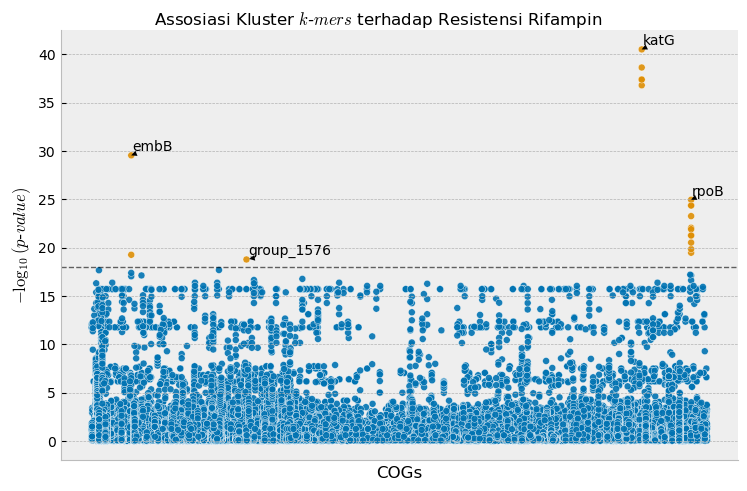

In [7]:
run_manhattan_pipeline('rifampin', 1e-18)

## 2. Distribusi Sampel

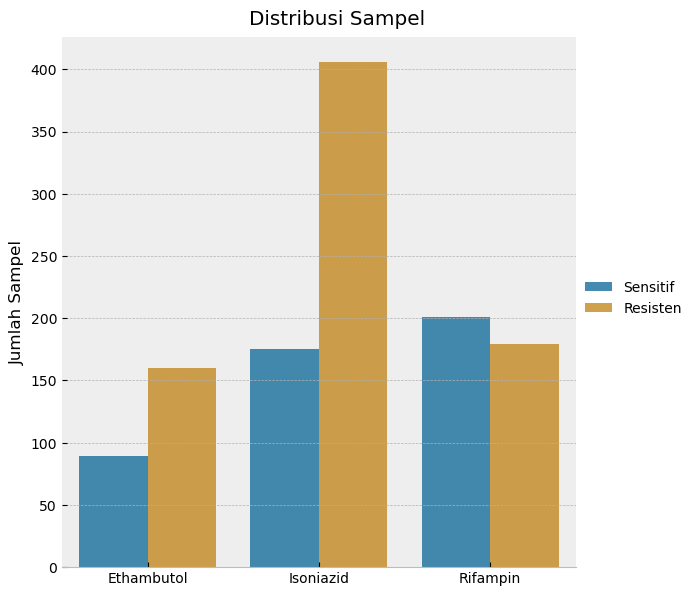

In [8]:
def get_traits(antibiotic):
    return pd.read_csv(path.join(DATA_DIR, f'traits_{antibiotic}.tsv'), sep='\t')


def count_traits(traits):
    return traits.groupby('resistance').count()['samples'].to_dict()


emb = 'ethambutol'
inh = 'isoniazid'
rif = 'rifampin'
r = 'Resisten'
s = 'Sensitif'

emb_count = count_traits(get_traits(emb))
inh_count = count_traits(get_traits(inh))
rif_count = count_traits(get_traits(rif))

distributions = pd.DataFrame(
    [(emb.title(), s, emb_count[0]),
     (emb.title(), r, emb_count[1]),
     (inh.title(), s, inh_count[0]),
     (inh.title(), r, inh_count[1]),
     (rif.title(), s, rif_count[0]),
     (rif.title(), r, rif_count[1])],
    columns=['antibiotic', 'trait', 'count'],
)


g = sns.catplot(
    data=distributions, kind='bar',
    x='antibiotic', y='count', hue='trait', 
    alpha=0.8, 
    height=6,
    palette='colorblind',
)
g.fig.suptitle(f'Distribusi Sampel', y=1.02, size='x-large')
g.despine(left=True)
g.set_axis_labels('', 'Jumlah Sampel')
g.legend.set_title('')

g.fig.savefig(path.join(FIG_DIR, f'distribusi_sampel.png'), format='png', dpi=600, bbox_inches='tight')